# Fluorescent Image Analysis Script 
Created 15/11/24 by Fraser Shields

## Workflow:
1. Import modules & packages
2. Loading image data 
3. Smoothing
4. Adaptive Thresholding
5. Optimising mask
6. ROI selection
7. Quantification of fluorescence 
8. Batch Processing


## Importing modules & packages

In [52]:
# The numerical array package numpy as np
import numpy as np

# The plotting module matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# The image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi


# Import pandas for data analysis 
import pandas as pd

# Set matplotlib backend
%matplotlib inline

## Loading image data

In [69]:
## Specify the directory path and filename 
filename = r'Composite_n3_3.tif'

dirpath = r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Main study\Primary\Histology\cq1 export\20240916T122344_HA_tray1_20xExport_20240920T121713\Projection\stitched_composite'

# join function to combine strings and take care of slashes 
from os.path import join

filepath = join(dirpath, filename)

print(filepath)


C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Main study\Primary\Histology\cq1 export\20240916T122344_HA_tray1_20xExport_20240920T121713\Projection\stitched_composite\Composite_n3_3.tif


In [56]:
## Load Image 

#  Import the function 'imread' from the module 'skimage.io'.
from skimage.io import imread

# Use imread function to load image as ndarray 
img = imread(filepath)

# Check type, shape and datatype of img file 
print("Loaded array is of type:", type(img))
print("Loaded array has shape:", img.shape)
print("Loaded values are of type:", img.dtype)


Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (2, 2160, 2560)
Loaded values are of type: uint16


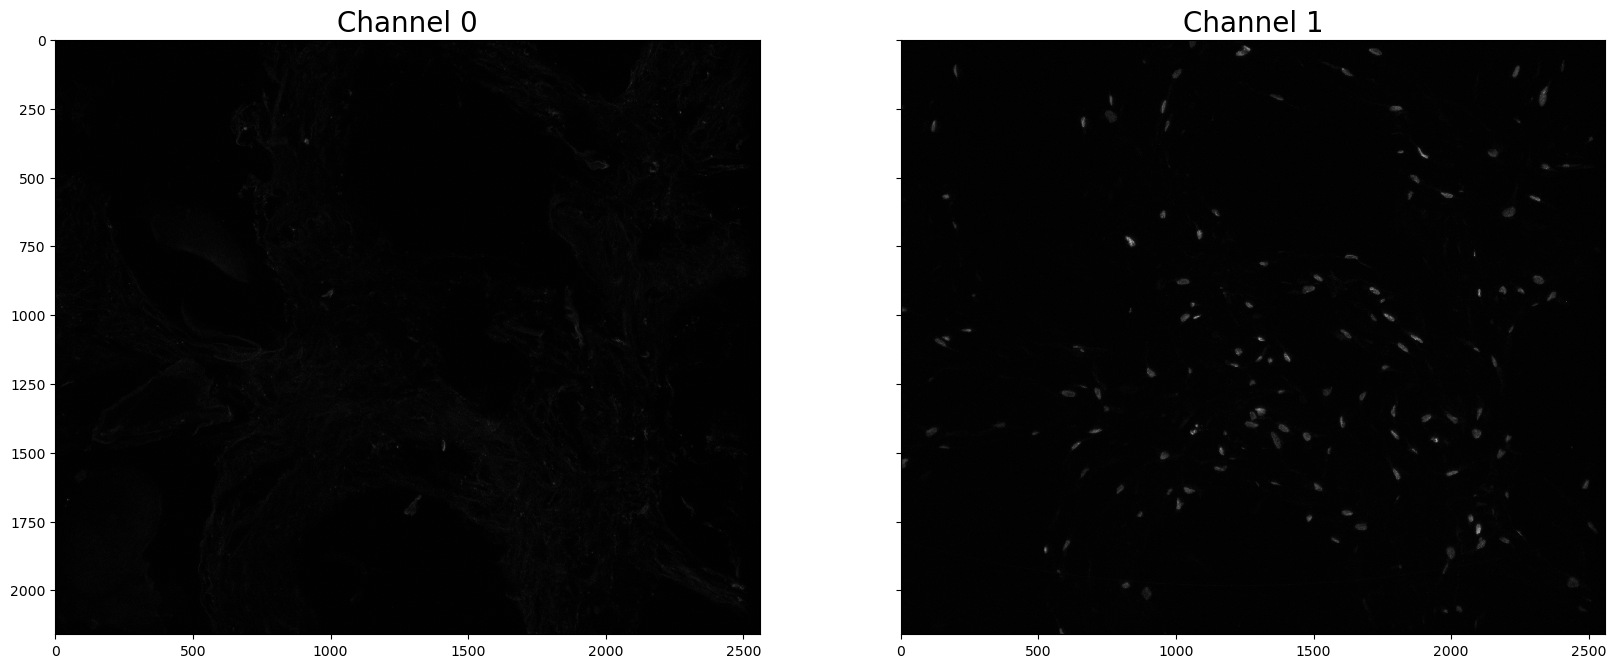

In [57]:
## Split image into seperate channels 
img_c0 = img[0, :, :]
img_c1 = img[1, :, :]

## Plot images 
from matplotlib.pyplot import subplots, show

fig, axs = subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))

axs[0].imshow(img_c0, interpolation='none', cmap='gray')
axs[0].set_title('Channel 0', fontsize=20)

axs[1].imshow(img_c1, interpolation='none', cmap='gray')
axs[1].set_title('Channel 1', fontsize=20)

show()


## Smoothing

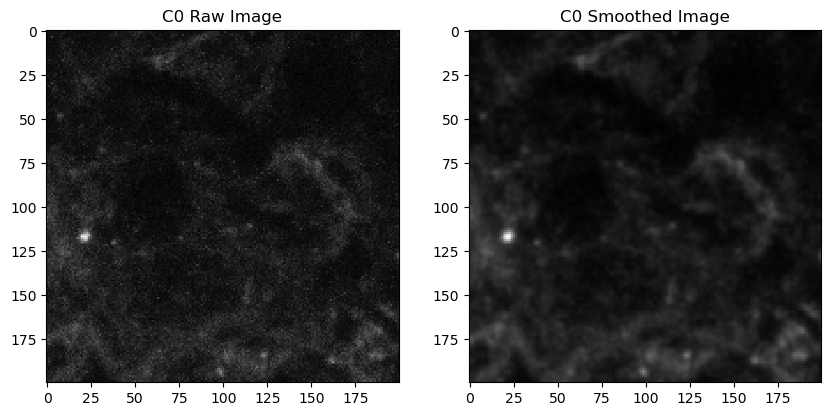

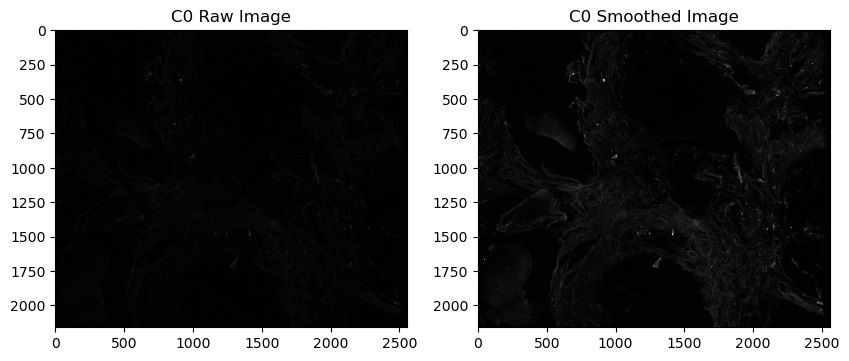

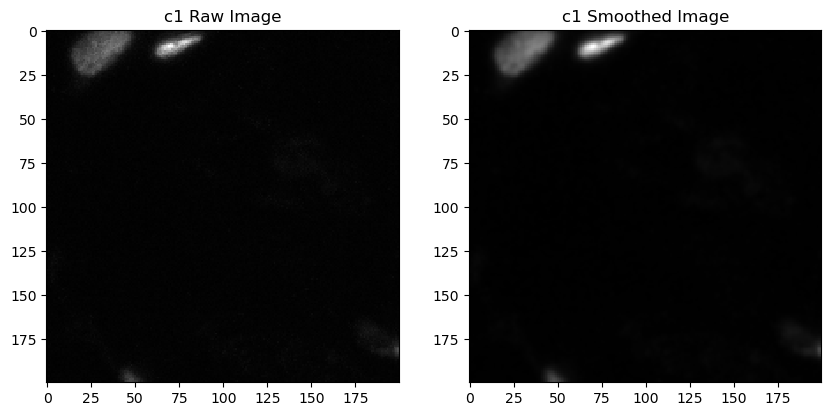

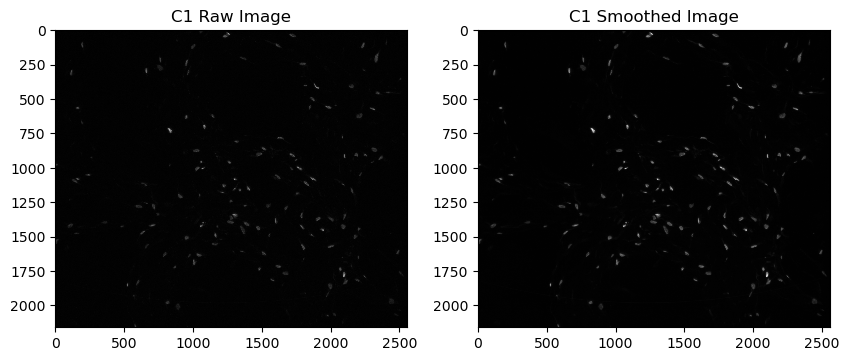

In [58]:
## Guassian Smoothing

# smoothing factor
sigma = 1

# perform smoothing
img_c0_smooth = ndi.gaussian_filter(img_c0, sigma)
img_c1_smooth = ndi.gaussian_filter(img_c1, sigma)

# C0

# plot maginified results
fig, axs = subplots(1, 2, figsize=(10,7))
axs[0].imshow(img_c0[1000:1200, 1000:1200], interpolation='none', cmap='gray')
axs[1].imshow(img_c0_smooth[1000:1200, 1000:1200], interpolation='none', cmap='gray')
axs[0].set_title('C0 Raw Image')
axs[1].set_title('C0 Smoothed Image')
plt.show()

# plot results
fig, axs = subplots(1, 2, figsize=(10,7))
axs[0].imshow(img_c0, interpolation='none', cmap='gray')
axs[1].imshow(img_c0_smooth, interpolation='none', cmap='gray')
axs[0].set_title('C0 Raw Image')
axs[1].set_title('C0 Smoothed Image')
plt.show()


# C1

# plot maginified results
fig, axs = subplots(1, 2, figsize=(10,7))
axs[0].imshow(img_c1[1000:1200, 1000:1200], interpolation='none', cmap='gray')
axs[1].imshow(img_c1_smooth[1000:1200, 1000:1200], interpolation='none', cmap='gray')
axs[0].set_title('c1 Raw Image')
axs[1].set_title('c1 Smoothed Image')
plt.show()

# plot results
fig, axs = subplots(1, 2, figsize=(10,7))
axs[0].imshow(img_c1, interpolation='none', cmap='gray')
axs[1].imshow(img_c1_smooth, interpolation='none', cmap='gray')
axs[0].set_title('C1 Raw Image')
axs[1].set_title('C1 Smoothed Image')
plt.show()

## Manual Thresholding

In [28]:
from ipywidgets import interact

@interact(thresh=(100,400,10))
def select_threshold(thresh=140):
    
    # Thresholding
    c0_man_thresh = img_c0_smooth > thresh
    c1_man_thresh = img_c1_smooth > thresh
    
    # Visualization
    fig, axs = subplots(ncols=2, nrows=1, figsize=(20,10))

    axs[0].imshow(c0_man_thresh, interpolation='none', cmap='gray')
    axs[0].set_title("Image 1 Thresholded")

    axs[1].imshow(c1_man_thresh, interpolation='none', cmap='gray')
    axs[1].set_title("Image 2 Thresholded")


interactive(children=(IntSlider(value=140, description='thresh', max=400, min=100, step=10), Output()), _dom_c…

## Adaptive Thresholding

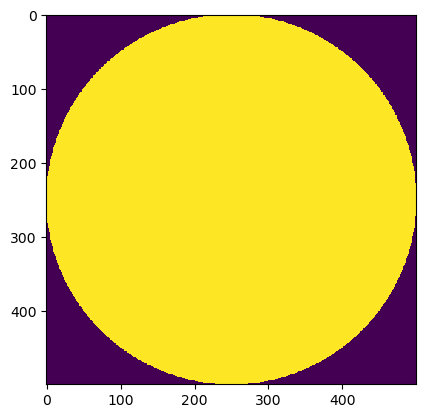

In [29]:
# Create SE
i = 500
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Visualize the result
plt.imshow(SE, interpolation='none')
plt.show()

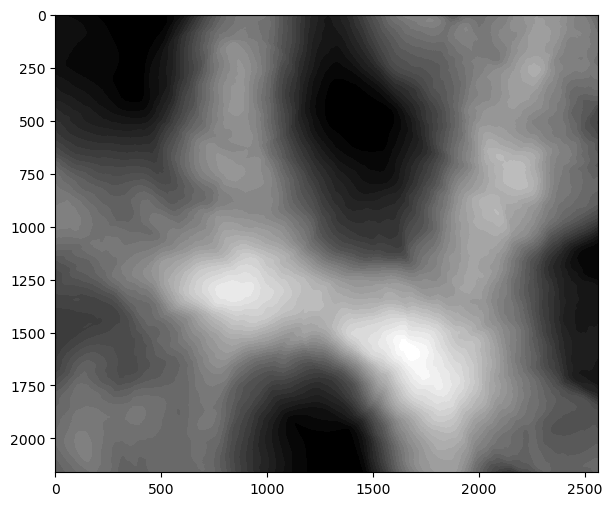

In [30]:
# Create the background

# Run a mean filter over the image using the disc SE and assign the output to a new variable.
# Use the function 'skimage.filters.rank.mean'.
from skimage.filters import rank 
bg = rank.mean(img_c0_smooth, footprint=SE)

# plot the resulting figure
plt.figure(figsize=(7,7))
plt.imshow(bg, interpolation='none', cmap='gray')
plt.show()


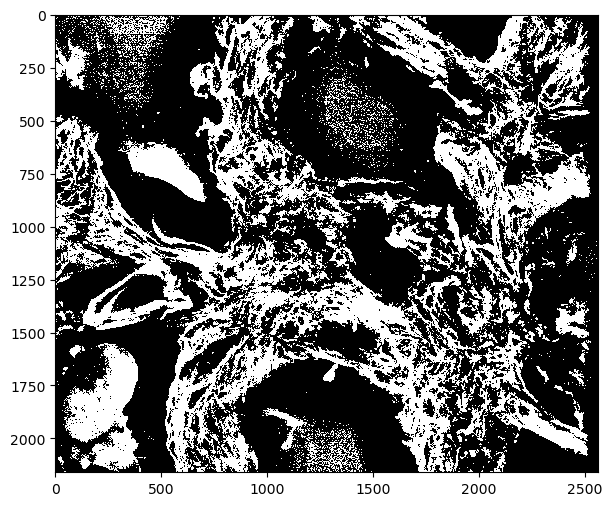

In [31]:
# Threshold the Gaussian-smoothed original image against the background image created in step 1 
#      using a relational expression

c0_mask = img_c0_smooth > bg

plt.figure(figsize=(7,7))
plt.imshow(c0_mask, interpolation='none', cmap='gray')
plt.show()

## Automated Thresholding Try All

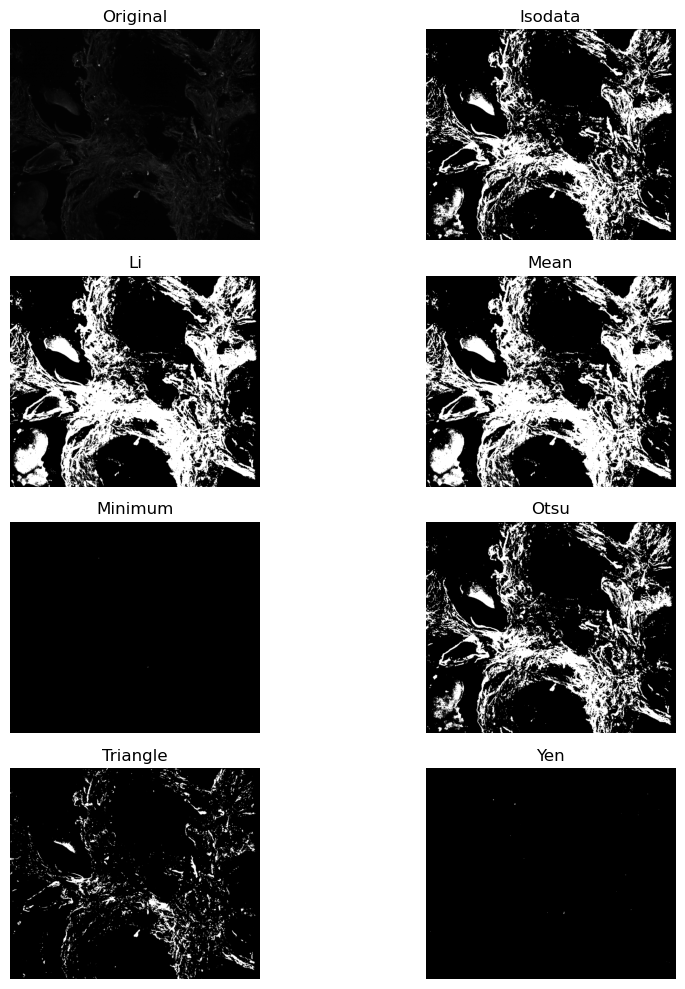

In [32]:
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(img_c0_smooth, figsize=(10,10), verbose=False)

## Automated Thresholding - Optimal

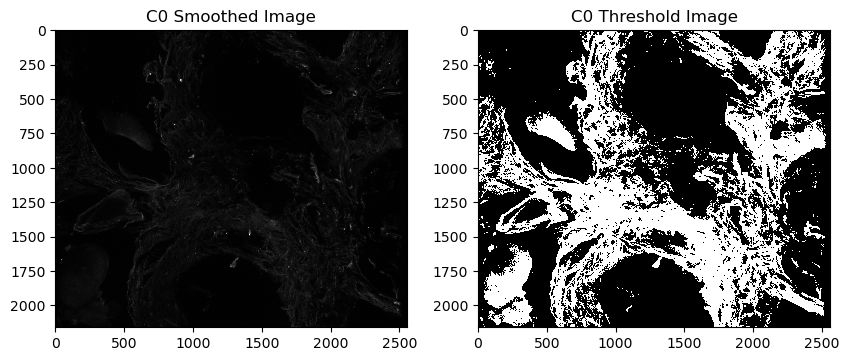

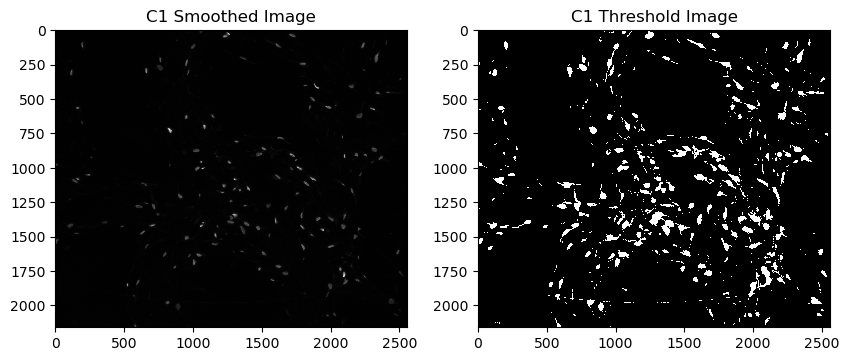

In [59]:
## Pick best threshold and apply
from skimage.filters.thresholding import threshold_li

# Apply Li Threshold
img_c0_thresh = threshold_li(img_c0_smooth)
img_c1_thresh = threshold_li(img_c1_smooth)

# Binarise the image 
img_c0_mask = img_c0_smooth > img_c0_thresh
img_c1_mask = img_c1_smooth > img_c0_thresh


# plot results
fig, axs = subplots(1, 2, figsize=(10,7))
axs[0].imshow(img_c0_smooth, interpolation='none', cmap='gray')
axs[1].imshow(img_c0_mask, interpolation='none', cmap='gray')
axs[0].set_title('C0 Smoothed Image')
axs[1].set_title('C0 Threshold Image')
plt.show()



# plot results
fig, axs = subplots(1, 2, figsize=(10,7))
axs[0].imshow(img_c1_smooth, interpolation='none', cmap='gray')
axs[1].imshow(img_c1_mask, interpolation='none', cmap='gray')
axs[0].set_title('C1 Smoothed Image')
axs[1].set_title('C1 Threshold Image')
plt.show()


## ROI Selection

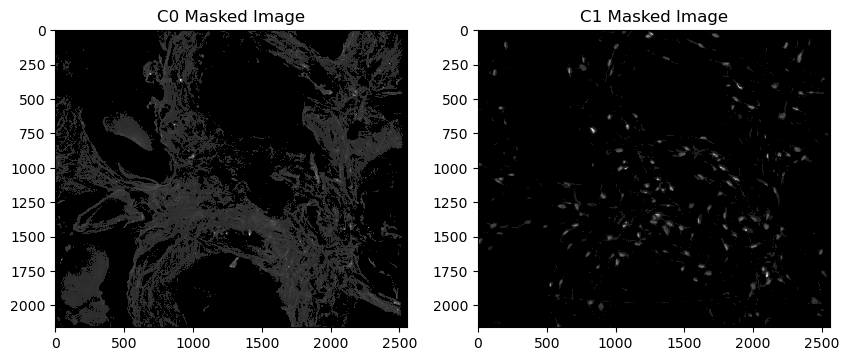

Total Fluorescence Intensity (C0): 280814085
Mask Area (C0): 1986789
Normalized Intensity (C0): 141.3406682843523
Total Fluorescence Intensity (C1): 61806540
Mask Area (C1): 319885
Normalized Intensity (C1): 193.21487409537804


In [60]:
# Apply the mask to the original image to isolate the region of interest
masked_img_c0 = img_c0_smooth * img_c0_mask
masked_img_c1 = img_c1_smooth * img_c1_mask

# Display the masked images
fig, axs = subplots(1, 2, figsize=(10, 7))
axs[0].imshow(masked_img_c0, interpolation='none', cmap='gray')
axs[1].imshow(masked_img_c1, interpolation='none', cmap='gray')
axs[0].set_title('C0 Masked Image')
axs[1].set_title('C1 Masked Image')
plt.show()

# Measure fluorescence intensity for each channel
intensity_c0 = masked_img_c0.sum()
intensity_c1 = masked_img_c1.sum()

# Calculate the mask area (number of non-zero pixels in the mask)
area_c0 = img_c0_mask.sum()
area_c1 = img_c1_mask.sum()

# Normalize intensity by mask area
intensity_per_area_c0 = intensity_c0 / area_c0
intensity_per_area_c1 = intensity_c1 / area_c1


# Display results
print(f"Total Fluorescence Intensity (C0): {intensity_c0}")
print(f"Mask Area (C0): {area_c0}")
print(f"Normalized Intensity (C0): {intensity_per_area_c0}")

print(f"Total Fluorescence Intensity (C1): {intensity_c1}")
print(f"Mask Area (C1): {area_c1}")
print(f"Normalized Intensity (C1): {intensity_per_area_c1}")

## Batch Processing

In [93]:
# Test batch processing function with test image 

from batch_processing import img_analysis_pipeline

dirpath = r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Main study\Primary\Histology\cq1 export\20240916T122344_HA_tray1_20xExport_20240920T121713\Projection\stitched_composite'

filename = f'Composite_n3_3.tif'

results_df = img_analysis_pipeline(dirpath, filename)

print(results_df)

[]


In [ ]:
# Iterate over the relevant input filenames and run the pipeline function

# Get all relevant filenames from directory 
dirpath = r'C:\Users\mbgm4fs3\OneDrive - The University of Manchester\PhD\Experimental\Data\5. Mechanical Stimulation\Main study\Primary\Histology\cq1 export\20240916T122344_HA_tray1_20xExport_20240920T121713\Projection\stitched_composite'

# Initialise empty dataframe 
all_results_df = pd.DataFrame()

# Loop through files in directory and apply pipeline function 
import os 

for filename in os.listdir(dirpath):
    if filename.endswith(".tif"):

        file_results_df = img_analysis_pipeline(dirpath, filename)

        all_results_df = pd.concat([all_results_df, file_results_df], ignore_index=True)

# print(all_results_df)

    


[]


TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid